

---
# Part I ⛳  Basics: environment, agent and tabular value-based RL
---



This tutorial is based on
- [Deep Learning Indaba](https://github.com/deep-learning-indaba/indaba-pracs-2022)
- [DeepMind Educational Resources](https://github.com/deepmind/educational)

Adapted by Ksenia Konyushkova with feedback from Lucas Maystre, Andrey Konyushkov, Nemanja Rakićević, and Pavlos Tosidis.

Note: in this tutorial we don't need to run the code on any accelerator, so you can select CPU kernel.

##🎉🎉🎉 Welcome to the Reinforcement Learning (RL) tutorial! 🎉🎉🎉

In this tutorial, we will be learning about Reinforcement Learning, a type of Machine Learning where an **agent** learns to choose **actions** in an **environment** that lead to maximal **reward** in the long run. RL has seen tremendous success on a wide range of challenging problems such as learning to play complex games like [Atari](https://www.deepmind.com/blog/agent57-outperforming-the-human-atari-benchmark), [StarCraft II](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii) and [Dota II](https://openai.com/five/) and [Go](https://www.nature.com/articles/nature16961).

Unlike fields like supervised learning, where we give examples of expected behaviour to our models, RL focuses on *goal-orientated* learning from interactions, through trial-and-error. RL algorithms learn what to do (i.e., which actions to take) in an environment to maximise some reward signal. In settings like a video game, the reward signal could be the score of the game, i.e., RL algorithms will try to maximise the score in the game by choosing the best actions.  

<center>
<img src="https://miro.medium.com/max/1400/1*Ews7HaMiSn2l8r70eeIszQ.png" width="40%" />
</center>

[*Image Source*](https://towardsdatascience.com/multi-agent-deep-reinforcement-learning-in-15-lines-of-code-using-pettingzoo-e0b963c0820b)

More precisely, in RL we have an **agent** which perceives an **observation** $o_t$ of the current state $s_t$ of the **environment** and must choose an **action** $a_t$ to take. The environment then transitions to a new state $s_{t+1}$ in response to the agent's action and also gives the agent a scalar reward $r_t$ to indicate how good or bad the chosen action was given the environment's state. The goal in RL is for the agent to maximise the amount of reward it receives from the environment over time. The subscript $t$ is used to indicate the timestep number. In this tutorial we will only consider fully observable games, which means thet state of the environment and observation of the agent are the same.

We will cover the following sections in this tutorial:

* **Environments** where we will either implement a simple environment or use a classical gym environment.
* **Agent-Environment loop** where we will see how agent and environment interact. We will consider the simplest possible agent for this: the agent that just takes a random action at each step.
* **Value-based reinforcement learning** where we will implement an agent that learns from its interactions with the environment which actions to take to achieve the highest reward.

In this colab you will find some

#### ⭐ Exercises
where you need to implement missing parts in the code, or answer the quesions that test your understanding of code and algothims.
When you need to complete some code, the section is marked as:

```
# -----------------------------------#
# You code goes here
# -----------------------------------#
```
with any comments to help you to complete the task. Sometimes it is useful to have a look at further code in the cell to understand which variables you need to assign in your implementation.
Some exercises only require you to answer the questions or experiment with the code.
You can skip bonus exercises if you are short on time as the rest of the content does not depend on them. You can use the Table of content on the left to vavigate the tutorial. Let's begin!


In [23]:
# Install dependencies
%%capture

!pip install dm_env
!pip install gym[accept-rom-license]
!pip install dm-acme[envs]
!pip install autorom[accept-rom-license]

In [24]:
# Imports

import collections
import random
from typing import Sequence

import dm_env
from dm_env import specs
from matplotlib import animation
from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import gym
from acme.wrappers import atari_wrapper, gym_wrapper
from acme import wrappers
from matplotlib.patches import namedtuple

rc('animation', html='jshtml')
import warnings
warnings.filterwarnings('ignore')

# Environments

In reinforcement learning, we do not start with a dataset, but with an environment. Environments in RL represent the task or problem that we are trying to solve. There are many types of environments, such as board or computer games, simulated robotics settings, etc.

In this tutorial, we will look in details at two simple environments: Catch and Cartpole.

## Create your own environment

We will use `dm_env` library to define the environment. We will rely on the example [Catch](https://github.com/deepmind/dm_env/blob/master/examples/catch.py). from the library. Catch is a simple game, which is often used as a test bed for RL algorithms.

In this environment, a ball drops from the top and the agent controls the paddle at the bottom via three possible  **actions**: `left`, `stay`, and `right`. The **reward** 🥕 is given at the end of the episode, and is either $+1$ for catching the ball or $-1$ dropping the ball (and $0$ in all intermediate steps). The **episode** ends when the ball reaches the bottom of the screen. The **return** is the discounted sum of rewards in an episode:

$${r}(\tau_i) = \sum_{t=1}^{T_i} \gamma^t {r_{i,t}},$$

where $T_i$ is the episode length.
The discount factor allows us to increase the importance of rewards received quickly and decrease the importance of rewards that take long to receive. In this environment the discount does not have a large role to play, so we  set it to $\gamma^t=1$ for now and for the rest of the tutorial consider return to be just the sum of rewards in an episode:
$${r}(\tau_i) = \sum_{t=1}^{T_i} {r_{i,t}}$$


### ⭐ Exercise
Read through the environment specification code. Fill in the missing code to complete the `Catch` class. In particular, you need to make sure the ball is moving down by one row at every timestep.

In [25]:
_ACTIONS = (-1, 0, 1)  # Move paddle left, no-op, move paddle right.

class Catch(dm_env.Environment):
  """A Catch environment built on the dm_env.Environment class.

  The agent must move a paddle to intercept falling balls. Falling balls only
  move downwards on the column they are in.

  The observation is an array with shape (rows, columns) containing binary
  values: 0 if a space is empty; 1 if it contains the paddle and 2 for a ball.

  The actions are discrete, and by default there are three available actions:
  move left, stay, and move right.

  The episode terminates when the ball reaches the bottom of the screen.
  """

  def __init__(self,
               rows: int = 10,
               columns: int = 5,
               discount: float = 1.0):
    """Initializes a new Catch environment.

    Args:
      rows: number of rows.
      columns: number of columns.
      discount: discount factor for calculating reward.
    """
    self._rows = rows
    self._columns = columns
    self._discount = discount
    self._board = np.zeros((rows, columns), dtype=np.float32)
    self._ball_x = None
    self._ball_y = None
    self._paddle_x = None
    self._reset_next_step = True

  def reset(self) -> dm_env.TimeStep:
    """Returns the first `TimeStep` of a new episode."""
    self._reset_next_step = False
    # Ball can drop from any column.
    self._ball_x = np.random.randint(self._columns)
    self._ball_y = 0  # Top of matrix.
    self._paddle_x = self._columns // 2  # Centre.

    return dm_env.restart(self._observation())

  def step(self, action: int) -> dm_env.TimeStep:
    """Updates the environment according to the action."""
    if self._reset_next_step:
      return self.reset()

    # Move the paddle.
    dx = _ACTIONS[action]  # Get action. dx = change in x position.
    # Clip to keep paddle in bounds of the environment matrix.
    self._paddle_x = np.clip(self._paddle_x + dx, 0, self._columns - 1)

    # -----------------------------------#
    # Drop the ball down one row: increase y coordinate of the ball by 1.
    self._ball_y += 1
    # -----------------------------------#

    # Check for termination.
    if self._ball_y == self._rows - 1:  # Ball has fallen below the rows.
      # Reward depends on whether the paddle is on the ball (positions match).
      reward = 1. if self._paddle_x == self._ball_x else -1.
      self._reset_next_step = True
      return dm_env.termination(reward=reward, observation=self._observation())

    return dm_env.transition(reward=0., observation=self._observation(),
                             discount=self._discount)

  def observation_spec(self) -> specs.BoundedArray:
    """Returns the observation spec."""
    return specs.BoundedArray(
        shape=self._board.shape,
        dtype=self._board.dtype,
        name='board',
        minimum=0,
        maximum=2)

  def action_spec(self) -> specs.DiscreteArray:
    """Returns the action spec."""
    return specs.DiscreteArray(
        dtype=int, num_values=len(_ACTIONS), name='action')

  def _observation(self) -> np.ndarray:
    self._board.fill(0.)
    self._board[self._ball_y, self._ball_x] = 2.
    self._board[self._rows - 1, self._paddle_x] = 1.

    return self._board.copy()

# Function to animate the observations
def animate(data, interval=200):
  fig = plt.figure(1)
  img = plt.imshow(data[0])
  plt.axis('off')

  def animate(i):
    img.set_data(data[i])

  anim = animation.FuncAnimation(fig, animate, frames=len(data), interval=interval)
  plt.close(1)
  return anim


Let's look at the types of objects the environment returns (observations) and consumes (actions). The `environment_spec` will show you the form of the **observations**, **rewards** and discounts that the environment exposes and the form of the **actions** that can be taken:

In [26]:
env = Catch(rows=10, columns=5)
print(env.observation_spec())
print(env.reward_spec())
print(env.action_spec())

BoundedArray(shape=(10, 5), dtype=dtype('float32'), name='board', minimum=0.0, maximum=2.0)
Array(shape=(), dtype=dtype('float64'), name='reward')
DiscreteArray(shape=(), dtype=int64, name=action, minimum=0, maximum=2, num_values=3)


### ⭐ Exercise

What does observation
```
[[0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 2.],
 [0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0.],
 [0., 0., 0., 0., 0.],
 [0., 1., 0., 0., 0.]]
```
represent? Does is correspond to `env.observation_spec()`?

We can see that by default the **observations** consist of a matrix of shape $(10, 5)$. You can change the size of the game by setting the `rows` and `columns` parameters to different values when creating an instance of a game. The **actions** is a $1$-D integer array with possible values $[0, 1, 2]$. Finally, the **reward** is a scalar.

Now we want to take an action using the `step` method to interact with the environment, which will return a `TimeStep` namedtuple with fields:

```
timestep = (step_type, reward, discount, observation)
```

**step_type**: indicates whether we're at the beginning, middle, or end of the episode. For more details, look [here](https://github.com/deepmind/dm_env/blob/master/dm_env/_environment.py#L32). For example, if you want to check if you are at the end of the episode, you can check if `step_type.last()` is `True`.

**reward**: is the reward returned by the environment at this step. Note that before we take an action the reward is `None`.

**discount**: is the discount factor $\gamma$ (will be set to $1$ for simplicity).

**observations**: our observations are zero everywhere except where the paddle is indicated by $1$ and ball is indicated by $2$.

We can visualise the observations after taking some actions as images.

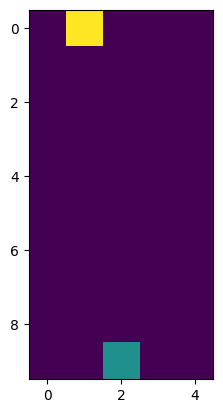


step_type: StepType.FIRST
reward: None
discount: None


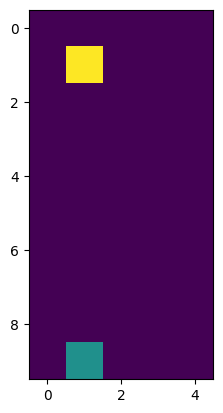


step_type: StepType.MID
reward: 0.0
discount: 1.0


In [27]:
# Reset and initialise the environment.
step_type, reward, discount, observation = env.reset()
plt.imshow(observation)
plt.show()
print('\nstep_type:', step_type)
print('reward:', reward)
print('discount:', discount)

# Let's take a single action.
step_type, reward, discount, observation = env.step(0)
plt.imshow(observation)
plt.show()

print('\nstep_type:', step_type)
print('reward:', reward)
print('discount:', discount)

### ⭐ Exercise

Make a game board with $3$ rows and $2$ colums. Take $2$ actions to go to the right (until the game is finished). Questions:
- what is the reward at the very first timestep?
- compute the return as sum of rewards in the episode.
- given that the ball's position is random at initialisation, what is the probability to catch the ball?

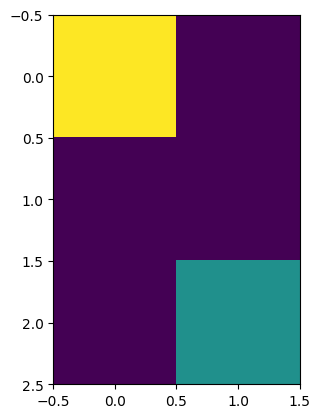

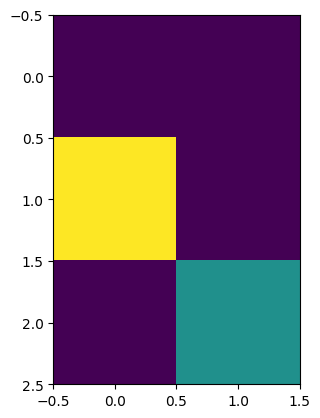

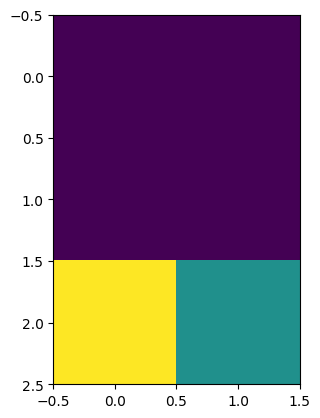

return= -1.0


In [28]:
# Make an environment
# -----------------------------------#
# Create an environment
env = Catch(rows=3, columns=2)
# -----------------------------------#

a_return = 0
# -----------------------------------#
# Reset and initialise the environment.
# Remember that reward is None and it does not need to be used for return computation.
step_type, reward, discount, observation = env.reset()
# -----------------------------------#
# show an observation
plt.imshow(observation)
plt.show()

# -----------------------------------#
# Go to the right
# Remember to add the reward to a_return
step_type, reward, discount, observation = env.step(1)
plt.imshow(observation)
# -----------------------------------#
plt.show()
# update a_return
a_return += reward

# -----------------------------------#
# Go to the right
# Remember to add the reward to a_return
step_type, reward, discount, observation = env.step(1)
plt.imshow(observation)
plt.show()
# update a_return
a_return += reward
# -----------------------------------#

print('return=', a_return)

## Use one of the gym environments

We will use a famous [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) or inverted pendulum environment.

<center><img src="https://user-images.githubusercontent.com/10624937/42135683-dde5c6f0-7d13-11e8-90b1-8770df3e40cf.gif" height="250" /></center>

From the documentation:

```A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. The action ... can take values $\{0, 1\}$ indicating the direction of the fixed force the cart is pushed with. The observation ... includes the values corresponding to the following positions and velocities: Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity. Since the goal is to keep the pole upright for as long as possible, a reward of $+1$ for every step taken, including the termination step, is allotted. At the starting state all observations are assigned a uniformly random value in $(-0.05, 0.05)$.```

Please heck the [documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to see more details about the environment.

Note that in this tutorial we will use *environement wrapper* in order to make the interface of the environment the same as `dm_env` so that we can swap them easily. This means that you can use the same functions as we used for Catch environment.

In [29]:
# Make an environment
env = gym_wrapper.GymWrapper(gym.make('CartPole-v1'))
env = wrappers.SinglePrecisionWrapper(env)

### ⭐ Exercise

What are the observation, action and reward spec? You the same functions for checking this as we used above for Catch.

In [30]:
# -----------------------------------#
# print observation spec
print(env.observation_spec())
# print action spec
print(env.action_spec())
# print reward spec
print(env.reward_spec())
# -----------------------------------#

BoundedArray(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])
DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=1, num_values=2)
Array(shape=(), dtype=dtype('float32'), name='reward')


### ⭐ Exercise

Let's reset the environment and then apply the force in one direction until the episode is terminated. Fill in the gaps and compute the retrun. Run the code several times. Does the sum of rewards change? Why? What is the average (not discounted) return?

In [31]:
# -----------------------------------#
# Reset the environment.
step_type, reward, discount, observation = env.reset()
# -----------------------------------#
print('reward = ', reward)

a_return = 0
# we can use step_type.last() to determine if an episode terminated
while not step_type.last():
  # -----------------------------------#
  # Go to the right
  step_type, reward, discount, observation = env.step(1)
  print('reward = ', reward)
  # update a_return
  a_return += reward
  # -----------------------------------#

print('Return=', a_return)

reward =  None
reward =  1.0
reward =  1.0
reward =  1.0
reward =  1.0
reward =  1.0
reward =  1.0
reward =  1.0
reward =  1.0
reward =  1.0
Return= 9.0


Let's visualise the environment frame

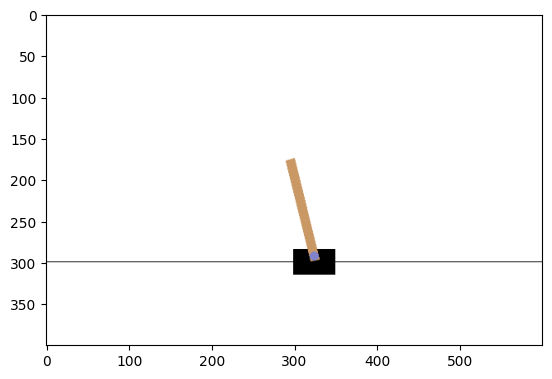

In [32]:
plt.imshow(env.render(mode='rgb_array'))

### ⭐ Bonus exercise

Load one of the other gym environments. Check what its specs are. Manually step through the environment. In atari, you can plot the observation which contains the game image.

This is how you can load the Mountain Car environment:
```
env = gym_wrapper.GymWrapper(gym.make('MountainCar-v0'))
env = wrappers.SinglePrecisionWrapper(env)
```

And this is how you can load some of the atari environments:
```
env = gym_wrapper.GymAtariAdapter(gym.make('Pong-v4'))
env = atari_wrapper.AtariWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)
```





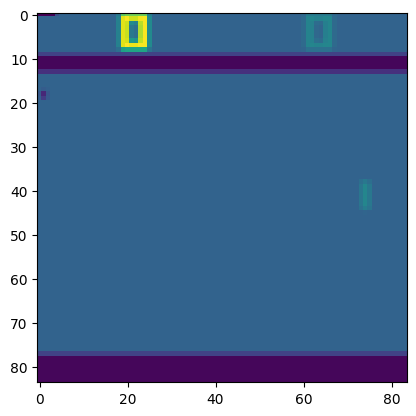

In [33]:
# -----------------------------------#
# env = gym_wrapper.GymWrapper(gym.make('MountainCar-v0'))
# env = wrappers.SinglePrecisionWrapper(env)

env = gym_wrapper.GymAtariAdapter(gym.make('Pong-v4'))
env = atari_wrapper.AtariWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)

step_type, reward0, discount, observation = env.reset()
plt.imshow(observation[:,:,3])
# -----------------------------------#

# Agent-Environment loop
We now turn to the agent. An agent receives the current **state** from the environment, and uses an internal **policy** to determine an **action** to take. We implement the agent as a Python [class](https://en.wikibooks.org/wiki/A_Beginner%27s_Python_Tutorial/Classes), which is just a logical wrapper of variables and methods (functions) that operate on those variables. The methods our first agent will have are the following:


* ```__init__```:  Initialises the agent the first time it's created.
* `actor_step`: Receives the timestep information from the environment and returns an action.



## Random Agent

To get a feel for an agent and the methods it has, let's first implement an agent that ignores the observations and just takes a *random* action at every step: for example, for Catch it decides to go righ, left or stay in place with equal probability.

### ⭐ Exercise

Fill in the gap in the random agent to return a random action. The main piece of information we need in order to implement this agent is the number of available actions in this environment (e.g., $3$ in Catch for going right, left or staying in place). We can get this information from the `num_values` attribute of an action spec `env.action_spec()`.

In [34]:
class RandomAgent(object):
  """An agent which simply takes random actions ignoring observations."""

  def __init__(self,
               action_spec: specs.DiscreteArray):
    # -----------------------------------#
    # _num_actions is the number of possible actions in the environment
    self._num_actions = action_spec.num_values
    # -----------------------------------#

  def actor_step(self, timestep: dm_env.TimeStep):
    # This agent is ignoring the observations, so we delete timestep
    del timestep
    # -----------------------------------#
    # Return a random integer between 0 and (self._num_actions - 1)
    # You can use np.random module here
    return np.random.randint(self._num_actions)
    # -----------------------------------#

## Run Loop

Now we can loop through the environment using our random agent until the environment is terminated. We call each sequence of interactions with the environment until the termination of the episode. From now on we will refer to the NamedTuple `timestep = (step_type, reward, discount, observation)`. Note how we use `step_type` to determin the end of the episode. Here we repeat the loop $10$ times.

### ⭐ Exercise

Fill in the gaps in the agent - environment loop with Catch environment. Compute the agent return at the end of each epsiode. What is the average return of the random agent?

In [35]:
num_episodes = 10  # @param

# Initialise Catch environment.
# -----------------------------------#
env = Catch()
# -----------------------------------#
# Initialise the agent.
agent = RandomAgent(env.action_spec())

all_returns = []
# Run loop.
for episode in range(num_episodes):
  timesteps = []  # Accumulate data for the episode.

  # Prepare agent, environment and accumulator for a new episode.
  # -----------------------------------#
  # reset the environment
  timestep = env.reset()
  # -----------------------------------#

  while not timestep.last():
    # Save the timestep
    timesteps.append(timestep)
    # -----------------------------------#
    # use agents actor_step method to select the action
    action = agent.actor_step(timestep)
    # -----------------------------------#
    # make a step in the environment and get the next timestep
    timestep = env.step(action)

  # Save the last timestep too.
  timesteps.append(timestep)

  # -----------------------------------#
  # Compute the return from a list of timesteps
  # Use can use timesteps.reward to access the reward
  # Remember: The first timestep is ignored as reward is None.
  returns = sum([x.reward for x in timesteps[1:]])
  # -----------------------------------#
  all_returns.append(returns)
  print(f'Episode {episode:}: Returns: {returns:.2f}.')
average_return = np.mean(all_returns)
print(f'Average return = {average_return:.2f}.')

Episode 0: Returns: 1.00.
Episode 1: Returns: -1.00.
Episode 2: Returns: -1.00.
Episode 3: Returns: -1.00.
Episode 4: Returns: -1.00.
Episode 5: Returns: -1.00.
Episode 6: Returns: -1.00.
Episode 7: Returns: -1.00.
Episode 8: Returns: 1.00.
Episode 9: Returns: -1.00.
Average return = -0.60.


We can now look at the game from the last episode.

In [36]:
animate([item.observation for item in timesteps])

### ⭐ Bonus exercise

- Experiment with the size of the game field (number of rows and number of columns). How does the average return vary with it?
- Consider, for example, the number of columns and rows between $2$ and $7$ and make a plot of the average return. To make the results less noisy, you might need to increase the number of episodes for each size.
- Which version of the game is the easiest? Which one is the hardest? What does it depend on?

Average return = -0.05.
Average return = -0.38.
Average return = -0.52.
Average return = -0.64.
Average return = -0.68.
Average return = 0.01.
Average return = -0.34.
Average return = -0.52.
Average return = -0.56.
Average return = -0.64.
Average return = 0.02.
Average return = -0.30.
Average return = -0.52.
Average return = -0.55.
Average return = -0.66.
Average return = 0.01.
Average return = -0.30.
Average return = -0.47.
Average return = -0.62.
Average return = -0.66.
Average return = 0.02.
Average return = -0.39.
Average return = -0.53.
Average return = -0.59.
Average return = -0.65.


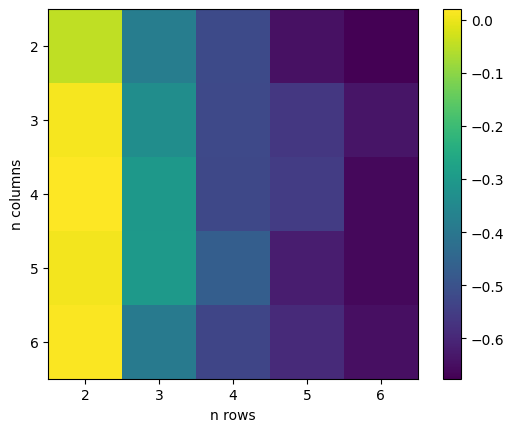

In [37]:
# -----------------------------------#
def compute_return(num_episodes, n_rows, n_columns):

  # Initialise the environment.
  env = Catch(rows=n_rows, columns=n_columns)
  timestep = env.reset()

  # Initialise the agent.
  agent = RandomAgent(env.action_spec())

  all_returns = []
  # Run loop.
  for episode in range(num_episodes):
    timesteps = []  # Accumulate data for the episode.

    # Prepare agent, environment and accumulator for a new episode.
    # reset the environment
    timestep = env.reset()

    while not timestep.last():
      timesteps.append(timestep)
      # use agents actor_step to select the action
      action = agent.actor_step(timestep)
      # make a step in the environment and get the next timestep
      timestep = env.step(action)

    # Save the last timestep too.
    timesteps.append(timestep)

    # Compute the return from a list of timesteps
    # Remember: The first timestep is ignored as reward is NaN.
    returns = sum([x.reward for x in timesteps[1:]])
    all_returns.append(returns)
  average_return = np.mean(all_returns)
  print(f'Average return = {average_return:.2f}.')
  return average_return

all_average_retuns = []
for n_rows in range(2,7):
  for n_columns in range(2,7):
    average_return = compute_return(1000, n_rows, n_columns)
    all_average_retuns.append(average_return)
plt.imshow(np.array(all_average_retuns).reshape(5,5))
plt.colorbar()
plt.xlabel('n rows')
plt.ylabel('n columns')
plt.xticks(range(0,5), [str(x) for x in range(2,7)]);
plt.yticks(range(0,5), [str(x) for x in range(2,7)]);
# -----------------------------------#

As the interface of CartPole environment is the same as for Catch, we can just replace the environment and run the same agent:

In [38]:
num_episodes = 10  # @param

# Initialise the environment.
env = gym_wrapper.GymWrapper(gym.make('CartPole-v1'))
env = wrappers.SinglePrecisionWrapper(env)

# Initialise the agent.
agent = RandomAgent(env.action_spec())

all_returns = []
# Run loop.
for episode in range(num_episodes):
  timesteps = []  # Accumulate data for the episode.

  # Prepare agent, environment and accumulator for a new episode.
  # reset the environment
  timestep = env.reset()

  frames = []
  while not timestep.last():
    frames.append(env.render(mode='rgb_array'))
    timesteps.append(timestep)
    # use agents actor_step to select the action
    action = agent.actor_step(timestep)
    # make a step in the environment and get the next timestep
    timestep = env.step(action)

  # Save the last timestep too.
  timesteps.append(timestep)

  # Compute the return from a list of timesteps
  # Remember: The first timestep is ignored as reward is NaN.
  returns = sum([x.reward for x in timesteps[1:]])
  all_returns.append(returns)
  print(f'Episode {episode:}: Returns: {returns:.2f}.')
average_return = np.mean(all_returns)
print(f'Average return = {average_return:.2f}.')
print('You are likely to get the average return between 15 and 30.')

Episode 0: Returns: 15.00.
Episode 1: Returns: 33.00.
Episode 2: Returns: 12.00.
Episode 3: Returns: 20.00.
Episode 4: Returns: 28.00.
Episode 5: Returns: 23.00.
Episode 6: Returns: 16.00.
Episode 7: Returns: 9.00.
Episode 8: Returns: 51.00.
Episode 9: Returns: 11.00.
Average return = 21.80.
You are likely to get the average return between 15 and 30.


In [39]:
animate(frames, interval=50)

# Value-Based Reinforcement Learning

Not surprisingly, our random agent is not really good at this game and we need to use some learning.

In **value-based** reinforcement learning methods, agents maintain a **value** for all **state-action** pairs. A **value** of a **state-action** pair is telling us what reward to expect if we start at this **state**, take this action and afterwards follow a policy. Then, we use these **value** estimates to choose actions that maximise the value.


## Q-learning

One efficient algorithm for value-based learning is [Q-learning](https://en.wikipedia.org/wiki/Q-learning).
The function that mapping state-action pairs to values for a specific policy $\pi$ is called **Q-function**.
Formally, **Q-function** is defined as:

$$ Q^{\pi}(s,a) = \mathbb{E}_{\tau \sim P^{\pi}} \left[ \sum_t \gamma^t R_t| s_0=s,a=a_0 \right]$$

where $\tau = \{s_0, a_0, r_0, s_1, a_1, r_1, \cdots \}$. In other words, $Q^{\pi}(s,a)$ is the expected **value** (sum of discounted rewards) of being in a given **state** $s$ and taking the **action** $a$ and then following policy ${\pi}$ thereafter.

Given a Q-function, it is easy to construct a good policy. For example, a greedy policy selects the action that maximises the Q-function estimate:
$$\pi_{greedy} (a|s) = \arg\max_a Q^{\pi}(s,a). $$

The value $V^\pi$ of a state is the expected $Q^\pi$ over possible actions:

$$V^\pi(s) = \sum_{a \in A} \pi(a |s) Q^\pi(s,a)$$

We will reply on famous Bellman Optimality Equation to estimate the Q-function:

$$ Q^\pi(s,a) =  r(s,a) + \gamma  \sum_{s'\in S} P(s' |s,a) V^\pi(s'). $$

It breaks down $Q^{\pi}(s,a)$ into 2 parts: the immediate reward associated with being in state $s$ and taking action $a$, and the discounted sum of all future rewards. Then, to learn the Q-function we can use [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning).
If we are given a sample of state $s$, action $a$, reward $r(s,a)$ and next state $s'$, we compute the TD-error $\delta$ of a policy $\pi_e$ as:

$$\delta = r(s,a) + \gamma Q(s', \underbrace{\pi_e(s'}_{a'})) − Q(s, a).$$
The first two terms is the Q-function estimate of $Q(s,a)$ through the immediate reward and Q-function of the next state, and the third term is the direct estimate of the Q-function.

Then, we will update the $Q$ value estimates at each step with the following update rule:

$$Q(s, a) \gets Q(s, a) + \alpha \delta, $$

where $\delta$ is a TD-error and $\alpha$ is a small learning step size will influence how quickly our $Q$ values will be updated given new observations.


## Tabular Q-learning

We will start with tabular Q-learning where Q-function is represented by a table with a value for every state and action. For this, we will need to enumerate all possible states and actions.

### Steps to implement Q-learning agent

We will modify the Random Agent in the following way:

1. **Represent Q values.** Our state space is the position of the ball and paddle in the grid so its size is $c*r*c$, where $r, c$ are the numbers of rows and columns, respectively. Our number of actions is $3$ (move left, stay, move right). So a tabular representation of $Q$ will be a matrix of size `(number of states, number of actions)=(c*r*c, 3)`.

2. **Implement a policy.** We will use a greedy policy that returns the action with the highest $Q$ value.

3. **Implement a learning step.** We need to add a new method to our agent class to do the learning step which updates the $Q$ values based on the data. We will call this new method  `learner_step`.

### Handling the data

To compute the loss, we need timestep information from both the current and last timesteps. Let's define a new class to handle the data. We will call this new class `TransitionAccumulator`. This class is not absolutely necessary in this simple tabular learning, but it will set the interface that we will reuse later.

At each timestep, we will save the data using the `push` method and retrieve data using the `sample` method. The `sample` method returns the previous observation in addition to the data for the current timestep.

In [40]:
Transition = collections.namedtuple(
    'Transition', 'obs_tm1 a_tm1 r_t discount_t obs_t')

class TransitionAccumulator:
  """Simple Python accumulator for transitions."""

  def __init__(self):
    self._prev = None
    self._action = None
    self._latest = None

  def push(self, env_output, action):
    self._prev = self._latest
    self._action = action
    self._latest = env_output

  def sample(self):
    return Transition(self._prev.observation, self._action, self._latest.reward,
                      self._latest.discount, self._latest.observation)

  def is_ready(self):
    """Checks if there is previous data stored."""
    return self._prev is not None

## Greedy agent

Now, let's follow similar interface to the Random agent and implement Q-learning agent.

### ⭐ Exercise

1) We implemented the `__init__` function that initialised the Q-function with $-1$ (attribute `_q`), have a look at this function and understand it.

2) We also implemented a helper `_obs_to_index` function that helps us to convert the observation represented as an image into the index of the Q-function table. Take an example of a state from before, and think about how it will be converted into an index.

3) Fill in the gaps in `actor_step`. First, use the helper funtion `_obs_to_index` in order to find the index that corresponds to the observation in the current timestep. Then, make sure we select the action that maximized the Q-function value.

4) Fill in the gaps in the `learner_step` function to compute the TD error as $$\delta = r(s,a) + \gamma Q(s', a')) − Q(s, a).$$

In [41]:
class QlearningAgent(object):
  """Q-learning agent."""

  def __init__(self,
               action_spec: specs.DiscreteArray,
               observation_spec: specs.DiscreteArray,
               step_size: float = 0.1):
    self._num_actions = action_spec.num_values
    self._step_size = step_size
    r, c = observation_spec.shape
    # variable for representing the Q-function
    # before we know anything, assume that all actions are bad
    self._q = -np.ones((c * r * c, self._num_actions))

  def _obs_to_index(self, obs):
    """Convert the observation into an index for accessing q values."""
    # The paddle location is always at the bottom.
    obs_shape = obs.shape
    paddle = np.where(obs[-1, :].flatten() == 1)[0][0]
    obs = obs.flatten().astype(int)
    # Case where the ball and paddle overlap.
    if obs.sum() == 1:
      ball = (obs_shape[0] - 1) * obs_shape[1]  + paddle
    else:
      ball = np.where(obs == 2)[0][0]
    return paddle * np.prod(obs_shape) + ball

  def actor_step(self, timestep):
    # -----------------------------------#
    # Find the index corresponding to the current observation
    observation_index = self._obs_to_index(timestep.observation)
    # Index into the Q value matrix.
    qvalue = self._q[observation_index]
    # Greedy policy: select the action that corresponds to the largest Q-value.
    selected_action = np.argmax(qvalue)
    # -----------------------------------#
    return selected_action

  def learner_step(self, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    # obs_tm1 corresponds to s
    # a_tm1 corresponds to a
    # obs_t corresponds to s'
    # Offline Q-value update.
    # Find the indices corresponding to both observations
    obs_t = self._obs_to_index(obs_t)
    obs_tm1 = self._obs_to_index(obs_tm1)
    # Greedy policy selects the action that maximises the Q-function
    a_t = np.argmax(self._q[obs_t])
    # -----------------------------------#
    # Compute TD error as indicated above
    td_error = r_t + discount_t * self._q[obs_t, a_t] - self._q[obs_tm1, a_tm1]
    # -----------------------------------#
    self._q[obs_tm1, a_tm1] += self._step_size * td_error
    return td_error

Let's test `actor_step`:

In [42]:
# Example of initialising the agent and making a dummy observation and selecting an action
env = Catch()
# Create an agent
agent = QlearningAgent(action_spec=env.action_spec(),
                       observation_spec=env.observation_spec())

# Make a fake observation
DummyTransition = collections.namedtuple(
    'DummyTransition', 'observation')
obs = np.zeros(env.observation_spec().shape, "float32")
obs[0,0]=2
obs[-1,-1]=1
dummy_timestep = DummyTransition(obs)

# Select an action
action_to_take = agent.actor_step(dummy_timestep)
print('Action = ', action_to_take)
print('Action should be 0')

Action =  0
Action should be 0


Let's test `learner_step`:

In [43]:
# Example of initialising the agent and making a dummy observation and selecting an action
env = Catch()
# Create an agent
agent = QlearningAgent(action_spec=env.action_spec(),
                       observation_spec=env.observation_spec())

# Make a fake observation
obs = np.zeros(env.observation_spec().shape, "float32")
obs[0,0]=2
obs[-1,-1]=1

# Select an action
td_error = agent.learner_step(obs, 0, 2, 0.9, obs)
print('td-error = ', td_error)
print('td-error should be 2.1')

td-error =  2.1
td-error should be 2.1


### Run Loop

Have a look again at the running loop of the random agent. The part that is missing now to make the greedy Q-learning is the `learner_step`. Note that we will need to run the environment for many episodes in order to gather sufficient data for learning. We will only evaluate our policy occasionally, every `evaluate_every` steps, to reduce the amount of logging info and computation.

### ⭐ Exercise

Add the learner step to complete the training loop. For this, `sample` the datapoint from `accumulator` and run the agent's `learning_step` on it.

In [44]:
train_episodes = 1_000  # @param
evaluate_every = 100  # @param
eval_episodes = 10  # @param

# Initialise the environment.
env = Catch()
timestep = env.reset()

# Build and initialise the agent.
agent = QlearningAgent(env.action_spec(),
                       env.observation_spec())

# Initialise the accumulator.
accumulator = TransitionAccumulator()

# Run loop
avg_returns = []

for episode in range(train_episodes):
  # Prepare agent, environment and accumulator for a new episode.
  timestep = env.reset()
  accumulator.push(timestep, None)
  while not timestep.last():
    # Acting.
    action = agent.actor_step(timestep)
    # Agent-environment interaction.
    timestep = env.step(action)
    # Accumulate experience.
    accumulator.push(timestep, action)
    if accumulator.is_ready():
      # -----------------------------------#
      # Learner step on sample from accumulator
      accumulator_sample = accumulator.sample()
      agent.learner_step(*accumulator_sample)
      # -----------------------------------#
   # Evaluation.
  if not episode % evaluate_every:
    returns = []
    for _ in range(eval_episodes):
      timestep = env.reset()
      timesteps = [timestep]
      while not timestep.last():
        action = agent.actor_step(timestep)
        timestep = env.step(action)
        timesteps.append(timestep)
      returns.append(np.sum([item.reward for item in timesteps[1:]]))

    avg_returns.append(np.mean(returns))
    print(f'Episode {episode:4d}: Average returns: {avg_returns[-1]:.2f}.')

Episode    0: Average returns: -0.80.
Episode  100: Average returns: -0.60.
Episode  200: Average returns: -0.60.
Episode  300: Average returns: -0.80.
Episode  400: Average returns: -0.80.
Episode  500: Average returns: -0.60.
Episode  600: Average returns: -0.60.
Episode  700: Average returns: -0.60.
Episode  800: Average returns: -0.20.
Episode  900: Average returns: -0.60.


### ⭐ Exercise

- Animate the last episode and plot the retun of the agent as a function of number of trainin episodes.

- Does the agent manage to solve the task? Experiment with the number of training episodes, does it help? **Answer:** in most cases it won't help, the agent does not learn a good policy.

- Look at the initialisation of the Q-function table, all the values are set to $-1$. What do you think would happen after updating the Q-function with an episode where an agent a) succeeds, b) fails in an episode? Do you see any problem here? For the ways to fix it, look at the next section. **Answer:** we initialises Q-funtion with -1 which is the worst possible value in this environment. It means that any random action would be better than that and after initial random actions, the greedy agent will just select the same action all the time.

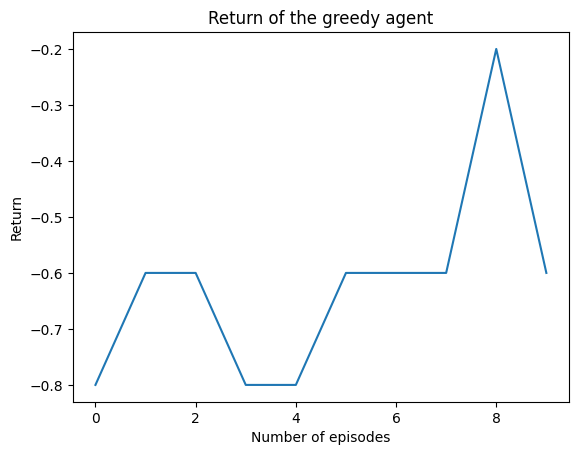

In [45]:
# -----------------------------------#
# Plot the average return as a function of number of episodes
plt.plot(avg_returns)
plt.xlabel('Number of episodes')
plt.ylabel('Return')
plt.title('Return of the greedy agent');
# -----------------------------------#

In [46]:
# -----------------------------------#
# Animate the last episode
animate([item.observation for item in timesteps])
# -----------------------------------#

## Epsilon-greedy agent

So, most of the time, a Q-learning agent fails to solve the task. One of the reasons for it is that the greedy policy with respect to a given estimate of $Q^\pi$ fails to *explore* the environment as needed. The problem is that our initialisation of the Q-function was "pessimistic" that means that once any of the actions is tried and is successful (by chance), the agent will keep selecting this action as it is "greedily" exploiting the Q-function estimate.

### ⭐ Exercise

One way to encourage exploration is to initialise the Q-funtion "optimistically", for example, with zeros or ones. Try modifying the agent above like this, what happens in this case? Hint: look at the line `self._q = -np.ones((c * r * c, self._num_actions))`

In [47]:
# Modify in the `__init__` function:
# self._q = np.ones((c * r * c, self._num_actions))

Optimistic initialisation might help us in this case, but a more general solution is to use **epsilon-greedy agent**. An $\epsilon$-greedy policy is a simple policy that at each time-step with probability $\epsilon$ will choose a random action instead of the greedy action. This ensures constant exploration  during learning.

### ⭐ Exercise

Update the QlearningAgent's policy to an $\epsilon$-greedy policy. Most things stays the same, but you need to modify `actor_step` function to select the best action with probability $1-\epsilon$ and a random action with probability $\epsilon$. Note that agent takes parameters `epsilon` at the initialisation now.

In [48]:
class EGQlearningAgent(object):
  """Epsilon-greedy Q learning agent."""

  def __init__(self,
               action_spec: specs.DiscreteArray,
               observation_spec: specs.DiscreteArray,
               epsilon: float = 0.1,
               step_size: float = 0.1):
    self._num_actions = action_spec.num_values
    self._epsilon = epsilon
    self._step_size = step_size
    r, c = observation_spec.shape
    # variable for representing the Q-function
    # before we know anything, assume that all actions are bad
    self._q = -np.ones((c * r * c, self._num_actions))

  def _obs_to_index(self, obs):
    """Convert the observation into an index for accessing q values."""
    # The paddle location is always at the bottom.
    obs_shape = obs.shape
    paddle = np.where(obs[-1, :].flatten() == 1)[0][0]
    obs = obs.flatten().astype(int)
    # Case where the ball and paddle overlap.
    if obs.sum() == 1:
      ball = (obs_shape[0] - 1) * obs_shape[1]  + paddle
    else:
      ball = np.where(obs == 2)[0][0]
    return paddle * np.prod(obs_shape) + ball

  def actor_step(self, timestep, evaluation):
    # Index into the Q value matrix.
    qvalue = self._q[self._obs_to_index(timestep.observation)]
    # Epsilon-greedy policy.
    # -----------------------------------#
    # With probability 1-self._epsilon, select the best action according to
    # qvalue as before
    if np.random.random() > self._epsilon:
      train_a = np.argmax(qvalue)
    # With probability self._epsilon, select a random action
    else:
      train_a = np.random.choice(self._num_actions)
    # -----------------------------------#
    if evaluation:
      # During evaluation, always select the best action according to qvalue
      return np.argmax(qvalue)
    else:
      return train_a

  def learner_step(self, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    # Offline Q-value update.
    obs_t = self._obs_to_index(obs_t)
    obs_tm1 = self._obs_to_index(obs_tm1)
    td_error = r_t + discount_t * np.max(self._q[obs_t]) - self._q[obs_tm1, a_tm1]
    self._q[obs_tm1, a_tm1] += self._step_size * td_error

Let's test `actor_step`.

In [49]:
# Example of initialising the agent and making a dummy observation and selecting an action
env = Catch()
# Create an agent
agent = EGQlearningAgent(action_spec=env.action_spec(),
                         observation_spec=env.observation_spec(),
                         epsilon=0.3)

# Make a fake observation
DummyTransition = collections.namedtuple(
    'DummyTransition', 'observation')
obs = np.zeros(env.observation_spec().shape, "float32")
obs[0,0]=2
obs[-1,-1]=1
dummy_timestep = DummyTransition(obs)

# Select an action
action_to_take = agent.actor_step(dummy_timestep, evaluation=False)
print('Action = ', action_to_take)
print('If you run this code several times, most of the time action would be 0, but sometimes 1 or 2.')

Action =  1
If you run this code several times, most of the time action would be 0, but sometimes 1 or 2.


### Run loop

Now let's run the training loop for an epsilon greedy agent

### ⭐ Exercise

Fill in the missing parameter values `train_episodes`, `epsilon`, and `step_size` to run the training loop

In [50]:
train_episodes = 1000  # @param
evaluate_every = 100  # @param
eval_episodes = 10  # @param
epsilon = 0.5  # @param
step_size = 0.2  # @param

# Initialise the environment.
env = Catch()
timestep = env.reset()

# Build and initialise the agent.
agent = EGQlearningAgent(env.action_spec(),
                         env.observation_spec(),
                         epsilon=epsilon,
                         step_size=step_size)

# Initialise the accumulator.
accumulator = TransitionAccumulator()

# Run loop.
avg_returns = []

for episode in range(train_episodes):

  # Prepare agent, environment and accumulator for a new episode.
  timestep = env.reset()
  accumulator.push(timestep, None)

  while not timestep.last():
    # Acting.
    action = agent.actor_step(timestep, False)
    # Agent-environment interaction.
    timestep = env.step(action)
    # Accumulate experience.
    accumulator.push(timestep, action)

    # Learning.
    if accumulator.is_ready():
      agent.learner_step(*accumulator.sample())

  # Evaluation.
  if not episode % evaluate_every:
    returns = []
    for _ in range(eval_episodes):
      timestep = env.reset()
      timesteps = [timestep]
      while not timestep.last():
        action = agent.actor_step(timestep, True)
        timestep = env.step(action)
        timesteps.append(timestep)
      returns.append(np.sum([item.reward for item in timesteps[1:]]))

    avg_returns.append(np.mean(returns))
    print(f"Episode {episode:4d}: Average returns: {avg_returns[-1]:.2f}.")

Episode    0: Average returns: -0.40.
Episode  100: Average returns: 0.20.
Episode  200: Average returns: 0.20.
Episode  300: Average returns: 0.20.
Episode  400: Average returns: 0.00.
Episode  500: Average returns: 0.20.
Episode  600: Average returns: -0.20.
Episode  700: Average returns: 0.40.
Episode  800: Average returns: 0.60.
Episode  900: Average returns: 0.00.


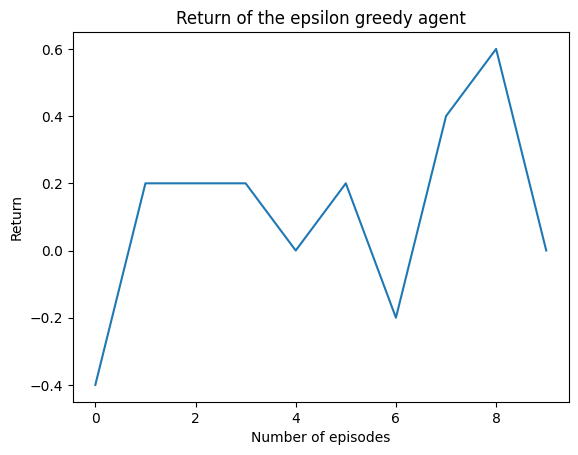

In [51]:
# Plot the average return as a function of number of epsiodes
plt.plot(avg_returns)
plt.xlabel('Number of episodes')
plt.ylabel('Return')
plt.title('Return of the epsilon greedy agent');

In [53]:
animate([item.observation for item in timesteps])

### ⭐ Exercise

- Does the agent manage to solve the task? Experiment with the number of training episodes, the exploration rate $\epsilon$ and learning step. Can an agent achieve the perferc score? **Answer:** the hyperparameters above should be good.

### ⭐ Bonus exercise

- Try to make the task harder: increase the size of the game board. Can the agent still solve this task?

- Sometimes you may notice that the agent's policy is not very natural (even if its return is 1): instead of going to the location where the ball is going to fall and waiting, it takes some other random actions before that. Why do you think this might happen? How could it be fixed?

🥳 Congratulations on completing the first part of this tutorial, great job!!!

It is the most important part as it sets the foundations which would allow you to understand more advanced RL algorithms. Next, we will look into Deep RL: when RL algorithms are combined with neural network training.